# Image classification with Vision Transformer
* This example implements the Vision Transformer (ViT) model by Alexey Dosovitskiy et al. for image classification, and demonstrates it on the CIFAR-100 dataset. The ViT model applies the Transformer architecture with self-attention to sequences of image patches, without using convolution layers.

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"  # specify which GPU(s) to be used

In [2]:
#!pip install -U tensorflow-addons==0.15.0

In [3]:
# Successfully uninstalled tensorflow-addons-0.15.0
# Successfully installed tensorflow-addons-0.19.0

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.8) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [5]:
tf.__version__

'2.7.0'

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

### Prepare the data

In [7]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()


In [8]:
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


### Configure the hyperparameters

In [9]:
learning_rate = 0.001
weight_decay = 0.0001
batch_size = 256
num_epochs = 100
image_size = 72  # We'll resize input images to this size
patch_size = 6  # Size of the patches to be extract from the input images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8
mlp_head_units = [2048, 1024]  # Size of the dense layers of the final classifier

### Use data augmentation

In [10]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)

In [11]:
data_augmentation.layers

In [12]:
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)

In [13]:
x_train.shape

(50000, 32, 32, 3)

In [14]:
data_augmentation.layers[0]

### Implement multilayer perceptron (MLP)

In [15]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

### Implement patch creation as a layer

In [16]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

Let's display patches for a sample image

(-0.5, 31.5, 31.5, -0.5)

<Figure size 288x288 with 0 Axes>

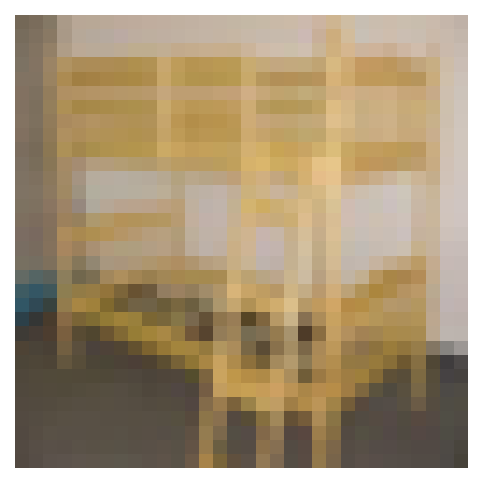

In [17]:
dpi=150
plt.figure(figsize=(4, 4))
idx = 36044#np.random.choice(range(x_train.shape[0]))
image = x_train[idx]
lbl = y_train[idx]
plt.figure(dpi=dpi)
plt.imshow(image.astype("uint8"))
plt.axis("off")
#plt.title('#{}'.format(idx))
#plt.title('#{} {}'.format(idx, lbl))

In [18]:
image_size

72

Image size: 72 X 72
Patch size: 6 X 6
Patches per image: 144
Elements per patch: 108
Patch shape : (1, 144, 108)


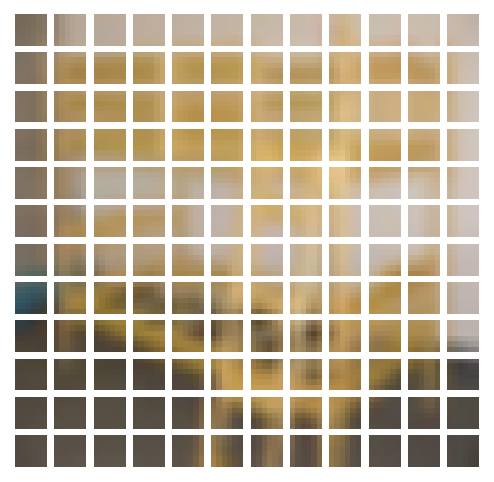

In [19]:
resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")
print(f"Patch shape : {patches.shape}")
n = int(np.sqrt(patches.shape[1]))
plt.figure(dpi=dpi, figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")

### Implement the patch encoding layer

The PatchEncoder layer will linearly transform a patch by projecting it into a vector of size projection_dim. In addition, it adds a learnable position embedding to the projected vector.

In [20]:
projection_dim

64

In [21]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

In [22]:
positions_test = tf.range(start=0, limit=num_patches, delta=1)
print(positions_test)

tf.Tensor(
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143], shape=(144,), dtype=int32)


In [23]:
position_embedding_test = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

In [24]:
pos_emb1 = position_embedding_test(positions_test) #(144, 64)

In [25]:
pos_emb1

<tf.Tensor: shape=(144, 64), dtype=float32, numpy=
array([[ 0.01418383, -0.02455223, -0.02815129, ..., -0.03807395,
        -0.00257187,  0.00553632],
       [-0.02521985,  0.01335287, -0.04696039, ..., -0.01748287,
        -0.03141016,  0.02003738],
       [-0.02805503, -0.02779734,  0.02490855, ...,  0.02688463,
         0.02694086, -0.04477291],
       ...,
       [-0.01620307, -0.03134841, -0.03363593, ..., -0.00122267,
         0.04522841, -0.00725664],
       [-0.0108522 ,  0.01707739,  0.00657201, ..., -0.02272382,
         0.03565505, -0.01230335],
       [-0.0266881 , -0.01426964,  0.03951578, ..., -0.02544856,
        -0.01034795, -0.01002843]], dtype=float32)>

### Build the ViT model

The ViT model consists of multiple Transformer blocks, which use the layers.MultiHeadAttention layer as a self-attention mechanism applied to the sequence of patches. The Transformer blocks produce a <strong>[batch_size, num_patches, projection_dim]</strong> tensor, which is processed via an classifier head with softmax to produce the final class probabilities output.

Unlike the technique described in the paper, which prepends a learnable embedding to the sequence of encoded patches to serve as the image representation, all the outputs of the final Transformer block are reshaped with layers.Flatten() and used as the image representation input to the classifier head. 

Note that the layers.GlobalAveragePooling1D layer could also be used instead to aggregate the outputs of the Transformer block, especially when the number of patches and the projection dimensions are large.

In [26]:
patch_size

6

In [27]:
input_shape

(32, 32, 3)

In [28]:
num_patches, projection_dim

(144, 64)

The Transformer blocks produce a [batch_size, num_patches, projection_dim] tensor. 이때 각 encoded_patches 는 
```
encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
```
(None, 144, 64) 의 shape을 가지게 됨. 각 patch 마다 64

위의 PatchEncoder는 아래처럼 구성됨
```
positions = tf.range(start=0, limit=self.num_patches, delta=1)
encoded = self.projection(patch) + self.position_embedding(positions)
```

In [29]:
transformer_layers

8

In [30]:
input_shape

(32, 32, 3)

In [31]:
def create_vit_classifier():
    inputs = layers.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    # (None, 144, 64)
    # print(encoded_patches.shape) 
    
    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches) # (None, 144, 64)
        
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

### Compile, train, and evaluate the mode

In [32]:
def run_experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
        ],
    )

    checkpoint_filepath = "/tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    return history

In [33]:
vit_classifier = create_vit_classifier()

In [34]:
history = run_experiment(vit_classifier)

Epoch 1/100
176/176 [==============================] - 54s 259ms/step - loss: 4.4667 - accuracy: 0.0471 - top-5-accuracy: 0.1665 - val_loss: 3.9142 - val_accuracy: 0.1080 - val_top-5-accuracy: 0.3194
Epoch 2/100
176/176 [==============================] - 47s 268ms/step - loss: 3.9440 - accuracy: 0.0981 - top-5-accuracy: 0.2918 - val_loss: 3.5633 - val_accuracy: 0.1584 - val_top-5-accuracy: 0.4094
Epoch 3/100
176/176 [==============================] - 49s 277ms/step - loss: 3.6814 - accuracy: 0.1328 - top-5-accuracy: 0.3711 - val_loss: 3.3548 - val_accuracy: 0.1966 - val_top-5-accuracy: 0.4696
Epoch 4/100
176/176 [==============================] - 49s 279ms/step - loss: 3.5018 - accuracy: 0.1634 - top-5-accuracy: 0.4217 - val_loss: 3.1757 - val_accuracy: 0.2276 - val_top-5-accuracy: 0.5084
Epoch 5/100
176/176 [==============================] - 50s 282ms/step - loss: 3.3495 - accuracy: 0.1930 - top-5-accuracy: 0.4679 - val_loss: 3.0780 - val_accuracy: 0.2408 - val_top-5-accuracy: 0.5336


Epoch 42/100
176/176 [==============================] - 51s 290ms/step - loss: 1.5503 - accuracy: 0.5664 - top-5-accuracy: 0.8565 - val_loss: 2.0075 - val_accuracy: 0.4832 - val_top-5-accuracy: 0.7660
Epoch 43/100
176/176 [==============================] - 51s 292ms/step - loss: 1.5279 - accuracy: 0.5695 - top-5-accuracy: 0.8595 - val_loss: 2.0052 - val_accuracy: 0.4920 - val_top-5-accuracy: 0.7692
Epoch 44/100
176/176 [==============================] - 50s 283ms/step - loss: 1.5029 - accuracy: 0.5736 - top-5-accuracy: 0.8645 - val_loss: 1.9997 - val_accuracy: 0.4846 - val_top-5-accuracy: 0.7746
Epoch 45/100
176/176 [==============================] - 50s 284ms/step - loss: 1.4836 - accuracy: 0.5824 - top-5-accuracy: 0.8684 - val_loss: 2.0029 - val_accuracy: 0.4880 - val_top-5-accuracy: 0.7740
Epoch 46/100
176/176 [==============================] - 50s 283ms/step - loss: 1.4680 - accuracy: 0.5849 - top-5-accuracy: 0.8701 - val_loss: 2.0224 - val_accuracy: 0.4870 - val_top-5-accuracy: 0.

Epoch 84/100
176/176 [==============================] - 50s 284ms/step - loss: 0.9230 - accuracy: 0.7258 - top-5-accuracy: 0.9464 - val_loss: 1.9841 - val_accuracy: 0.5226 - val_top-5-accuracy: 0.7968
Epoch 85/100
176/176 [==============================] - 50s 284ms/step - loss: 0.9331 - accuracy: 0.7215 - top-5-accuracy: 0.9442 - val_loss: 1.9847 - val_accuracy: 0.5172 - val_top-5-accuracy: 0.7966
Epoch 86/100
176/176 [==============================] - 49s 281ms/step - loss: 0.9173 - accuracy: 0.7272 - top-5-accuracy: 0.9474 - val_loss: 1.9857 - val_accuracy: 0.5216 - val_top-5-accuracy: 0.7968
Epoch 87/100
176/176 [==============================] - 50s 283ms/step - loss: 0.9077 - accuracy: 0.7277 - top-5-accuracy: 0.9478 - val_loss: 1.9808 - val_accuracy: 0.5214 - val_top-5-accuracy: 0.7958
Epoch 88/100
176/176 [==============================] - 51s 291ms/step - loss: 0.9031 - accuracy: 0.7296 - top-5-accuracy: 0.9484 - val_loss: 1.9690 - val_accuracy: 0.5330 - val_top-5-accuracy: 0.

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



After 100 epochs, the ViT model achieves around 55% accuracy and 82% top-5 accuracy on the test data. These are not competitive results on the CIFAR-100 dataset, as a ResNet50V2 trained from scratch on the same data can achieve 67% accuracy.

Note that the state of the art results reported in the paper are achieved by pre-training the ViT model using the JFT-300M dataset, then fine-tuning it on the target dataset. To improve the model quality without pre-training, you can try to train the model for more epochs, use a larger number of Transformer layers, resize the input images, change the patch size, or increase the projection dimensions. Besides, as mentioned in the paper, the quality of the model is affected not only by architecture choices, but also by parameters such as the learning rate schedule, optimizer, weight decay, etc. In practice, it's recommended to fine-tune a ViT model that was pre-trained using a large, high-resolution dataset.

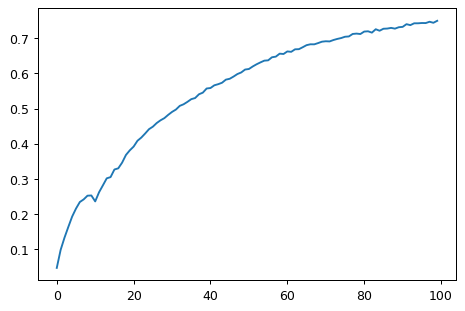

In [35]:
plt.figure(dpi=90)
plt.plot(history.history['accuracy'])

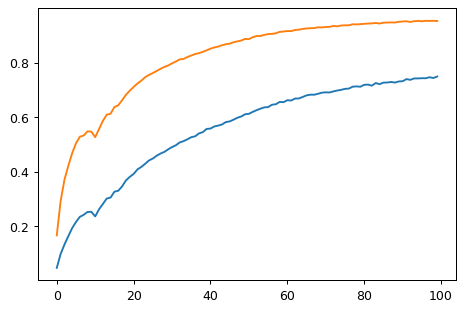

In [36]:
plt.figure(dpi=90)
plt.plot(history.history['accuracy'])
plt.plot(history.history['top-5-accuracy'])

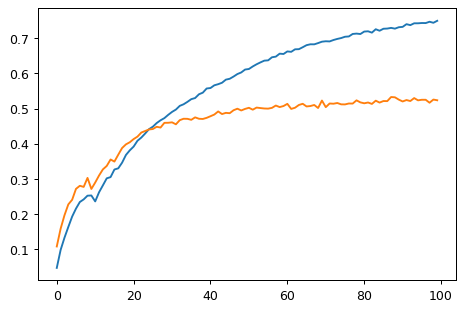

In [37]:
plt.figure(dpi=90)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

* https://keras.io/examples/vision/image_classification_with_vision_transformer/#introduction